In [2]:
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import random
import math
from scipy.io import mmread
from itertools import combinations
from torch.nn.functional import gumbel_softmax
from utils import gumbel_softmax_3d

In [3]:
# load data
def load_graph(filename):
    G = nx.Graph() # undirected graphs
    for line in open(filename):
        strlist = line.split(' ')
        n1 = int(strlist[0])
        n2 = int(strlist[1])
#         weight = float(strlist[w_index])
#         G.add_weighted_edges_from([(n1, n2, weight)])
        G.add_edges_from([(n1, n2)])
    return G

In [4]:
# load data
def load_graph2(filename):
    G = nx.Graph() # undirected graphs
    for line in open(filename):
        strlist = line.split(',')
        n1 = int(strlist[0])
        n2 = int(strlist[1])
#         weight = float(strlist[w_index])
#         G.add_weighted_edges_from([(n1, n2, weight)])
        G.add_edges_from([(n1, n2)])
    return G

In [80]:
# Jazz
# load data
# print('\nJazz\n')
data = mmread('./data/jazz.mtx')
F = nx.from_scipy_sparse_matrix(data)
G = nx.Graph()
for edge in F.edges():
    G.add_edges_from([edge])

In [ ]:
G = load_graph('./data/bio-celegans.edges')

In [95]:
G = load_graph('./data/email-univ.edges')

In [5]:
G = load_graph2('./data/fb-pages-government.edges')

In [87]:
G = nx.karate_club_graph()

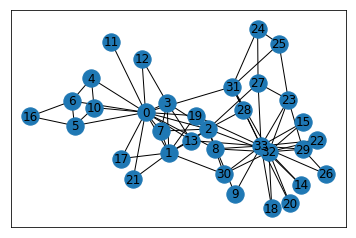

In [15]:
pos=nx.layout.spring_layout(G)
nx.draw_networkx(G, pos)

In [6]:
device = 'cuda:4'

nnodes = G.number_of_nodes()
nedges = G.number_of_edges()

A = nx.adjacency_matrix(G)
B = nx.to_numpy_array(G)
#print(A)
#print(B)
A = torch.from_numpy(B)
A = A.type(torch.float32)
print(A)
print(B)

t = np.log10(nnodes) / np.log10(2 * nedges / nnodes)
t = math.ceil(t)
print('网络直径：',t)

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
网络直径： 3


# 转移矩阵

In [7]:
transfer_matrix = torch.zeros_like(A,device=device)
for i in range(nnodes):
    transfer_matrix[i,:] = 1 / G.degree(i)
print(transfer_matrix)
transfer_matrix = transfer_matrix * A.cuda(4)
print(transfer_matrix)
#transfer_matrix *= 1 / t
transfer_matrix += torch.eye(nnodes,device=device)
print(transfer_matrix)

tensor([[0.0141, 0.0141, 0.0141,  ..., 0.0141, 0.0141, 0.0141],
        [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
        [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556]],
       device='cuda:4')
tensor([[0.0000, 0.0141, 0.0141,  ..., 0.0000, 0.0000, 0.0000],
        [0.0286, 0.0000, 0.0286,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:4')
tensor([[1.0000, 0.0141, 0.0141,  ..., 0.0000, 0.0000, 0.0000],
        [0.0286, 1.0000, 0.0286,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0

In [97]:
transfer_matrix = torch.zeros_like(A,device=device)
for i in range(nnodes):
    transfer_matrix[i,:] = 1 / G.degree(i + 1)
print(transfer_matrix)
transfer_matrix = transfer_matrix * A.cuda(4)
print(transfer_matrix)
#transfer_matrix *= 1 / t
transfer_matrix += torch.eye(nnodes,device=device)
print(transfer_matrix)

tensor([[0.0333, 0.0333, 0.0333,  ..., 0.0333, 0.0333, 0.0333],
        [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
        [0.0263, 0.0263, 0.0263,  ..., 0.0263, 0.0263, 0.0263],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:4')
tensor([[0.0000, 0.0333, 0.0333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0435, 0.0000, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        [0.0263, 0.0263, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:4')
tensor([[1.0000, 0.0333, 0.0333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0435, 1.0000, 0.0435,  ..., 0.0000, 0.0000, 0.0000],
        [0.0263, 0.0263, 1.0

# 并行GSO

In [8]:
class log(object):
    def __init__(self):
        self.inf = [];
        self.config = [];
        
t = np.log10(nnodes) / np.log10(2 * nedges / nnodes)
t = math.ceil(t)
print(t)

3


In [19]:
#torch.manual_seed(2050)
bs = 128
n = nnodes
init_tau = 3
final_tau = 0.1

#mu = 3
#sigma = 5
#decay = (init_tau - final_tau) / epoch

t = np.log10(nnodes) / np.log10(2 * nedges / nnodes)
t = math.ceil(t)
print(t)

ones = torch.ones(bs, nnodes, device=device)
lr = 1

eta0 = 5
eta1 = 1
num = 5
exp = 2
epoch = 2000
instance = 100

tau = init_tau
a = b = c = d = 0
ll = log()
lins = []

x = torch.randn(bs, n, 1, device=device) * 1e-5
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=lr)

for _ in range(instance):
    ll = log()
    optimizer.zero_grad()
    x = torch.randn(bs, n, 1, device=device) * 1e-5
    x.requires_grad = True
    optimizer = torch.optim.Adam([x], lr=lr)
    cost = torch.zeros(bs, device=device)
    a = b = c = d = 0
    for i in range(epoch):
        optimizer.zero_grad()
        probs = torch.empty(bs, n, 2, device=device)
        p = torch.sigmoid(x)
        probs[:, :, 0] = p.squeeze()
        probs[:, :, -1] = 1-probs[:, :, 0]
        logits = torch.log(probs+1e-10)
        s = gumbel_softmax_3d(logits, tau=tau, hard=True)[:, :, 0]
        #tau -= decay
        #s = torch.unsqueeze(s, -1)  # size [bs, n, 1]
        #print(s)
        #print(s.size())
        
        restmp = s
        
        #restmp = s.unsqueeze(0)
        #print(restmp)
        #print(restmp.size())
        #print(transfer_matrix.size())
        #sdfs
        #for i in range(bs):
            #restmp[i,:] = restmp[i,:] / torch.sum(restmp, 1)[i]
        #print(restmp)
        #print(torch.sum(restmp, 1))
        #print(torch.sum(restmp))
    
        #print(transfer_matrix)
        #print(restmp.size())
    
        for j in range(t):
            res = torch.mm(restmp, transfer_matrix)
            #print(i, "\t", res)
            res = torch.min(res, ones)
            #print(torch.sum(res))
            #print(torch.var(res))
            restmp = res
            #print(restmp)
            #print(torch.sum(restmp, 1))
            #print(torch.sum(restmp))
        
        #print('restmp:',restmp)
        
        
        cost_ = torch.sum(s, dim=1)
        #print(cost_)


        cost_ = eta0 * ((cost_ - num) ** exp)
        cost = torch.sum(cost_)
    
        inf = torch.sum(restmp)
    
        loss = -inf + eta1 * cost
    
        #print(i,':')
        #print('loss:',loss.item())
        #print('inf:',inf.item())
        #print('cost:',cost.item())
        
        with torch.no_grad():
            constraint = cost_.cpu().numpy()
            #print(constraint)
            idx0 = np.argwhere(constraint == 0)
            idx1 = np.argwhere(constraint == eta0)
            idx2 = np.argwhere(constraint == eta0 * (2 ** exp))

            idc0 = len(idx0)
            idc1 = len(idx1)
            idc2 = len(idx2)

            idce = bs - (idc0 + idc1 + idc2)
            a += idc0
            b += idc1
            c += idc2
            d += idce
            
            if idc0 != 0:
                #for k in idx0:
                #    k = k.item()
                #    E_now = torch.sum(restmp[k, :])
                #    #print(E_now)
                #    if E_now >= maxinf:
                #        maxinf = E_now.item()
                #        constraint = s[k, :].cpu().numpy()
                #        idx = np.argwhere(constraint == 1)
                Ei = torch.sum(restmp[idx0, :], dim=2).squeeze()
                Emax = Ei.max().item()
                Eindex = idx0[torch.argmax(Ei)]
                Es = s[Eindex, :].squeeze().cpu().numpy()
                idx = np.argwhere(Es == 1)

                ll.inf.append(Emax)
                #constraint = s.cpu().numpy()
                #idx = np.argwhere(constraint == 1)
                idx = idx.reshape(len(idx)).tolist()
                ll.config.append(idx)
                #print('config:',s.cpu().numpy())
        
        #print(i)
        loss.backward()
        optimizer.step()
    
        if i % 1000 == 0:
            print(i)

    #print(ll.inf.sort())
    print('\n',_)
    print(a,b,c,d)
    print(max(ll.inf))
    lins.append(max(ll.inf))
    print(ll.config[ll.inf.index(max(ll.inf))])
    print('percentage:',100 * a / (bs * epoch),'%')
    print(max(lins))

3
0
1000

 0
308 660 662 254370
4704.82958984375
[29, 87, 307, 833, 2361]
percentage: 0.1203125 %
4704.82958984375
0
1000

 1
331 621 669 254379
4715.4443359375
[2, 87, 515, 638, 1954]
percentage: 0.129296875 %
4715.4443359375
0
1000

 2
328 622 685 254365
4655.9892578125
[87, 93, 307, 638, 647]
percentage: 0.128125 %
4715.4443359375
0
1000

 3
311 621 627 254441
4652.306640625
[29, 87, 135, 819, 4537]
percentage: 0.121484375 %
4715.4443359375
0
1000

 4
324 655 682 254339
4669.9716796875
[2, 87, 93, 819, 946]
percentage: 0.1265625 %
4715.4443359375
0
1000

 5
301 638 739 254322
4835.84326171875
[2, 87, 135, 307, 638]
percentage: 0.117578125 %
4835.84326171875
0
1000

 6
300 666 716 254318
4753.8271484375
[29, 87, 93, 515, 638]
percentage: 0.1171875 %
4835.84326171875
0
1000

 7
323 629 661 254387
4816.8896484375
[29, 87, 135, 638, 819]
percentage: 0.126171875 %
4835.84326171875
0
1000

 8
324 651 641 254384
4707.7431640625
[87, 93, 307, 638, 1954]
percentage: 0.1265625 %
4835.84326171

1000

 73
355 636 636 254373
4831.64453125
[29, 87, 135, 307, 638]
percentage: 0.138671875 %
4905.06298828125
0
1000

 74
322 599 670 254409
4831.64453125
[29, 87, 135, 307, 638]
percentage: 0.12578125 %
4905.06298828125
0
1000

 75
319 620 688 254373
4658.83203125
[2, 87, 93, 1207, 1801]
percentage: 0.124609375 %
4905.06298828125
0
1000

 76
334 669 728 254269
4811.53515625
[29, 87, 93, 638, 1954]
percentage: 0.13046875 %
4905.06298828125
0
1000

 77
311 649 650 254390
4845.40234375
[2, 87, 307, 638, 946]
percentage: 0.121484375 %
4905.06298828125
0
1000

 78
313 703 650 254334
4658.36083984375
[29, 87, 93, 819, 1954]
percentage: 0.122265625 %
4905.06298828125
0
1000

 79
301 628 663 254408
4680.35400390625
[87, 135, 638, 1954, 4914]
percentage: 0.117578125 %
4905.06298828125
0
1000

 80
329 603 661 254407
4756.1796875
[2, 87, 307, 819, 946]
percentage: 0.128515625 %
4905.06298828125
0
1000

 81
360 646 667 254327
4905.06298828125
[2, 29, 87, 135, 638]
percentage: 0.140625 %
4905.0629